In [1]:
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from config import setup_logging
from extract import MatchDataLoader
from transform import transform_tracking_to_long_format, get_possession_frames, analyze_block_by_ball_position

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Reload modules when code is changed (uncomment for development)
%load_ext autoreload
%autoreload 2

# Init logging
logger = setup_logging(log_file="../logs/dominance_analysis.log")

# 1. Load data

In [2]:
# Initialize data loader
loader = MatchDataLoader()

# Load all data
events_data, player_data, tracking_data, mapping_data = loader.load_all_data()

2025-11-12 12:00:22,933 - extract.data_loading - INFO - ✓ Loaded 1710 events from ../data/20251010-Belgium-North-Macedonia/events.json
2025-11-12 12:00:22,934 - extract.data_loading - INFO - ✓ Loaded 32 players from ../data/20251010-Belgium-North-Macedonia/events.json
2025-11-12 12:00:23,703 - extract.data_loading - INFO - ✓ Loaded 145567 tracking entries from ../data/20251010-Belgium-North-Macedonia/tracking.pkl
2025-11-12 12:00:23,706 - extract.data_loading - INFO - ✓ Loaded mapping data from ../data/20251010-Belgium-North-Macedonia/mapping.json


## 2. Entry zone analyse

In [3]:
events_data.head()

,eventId,playerId,timestamp,playerName,groupId,groupName,teamId,teamName,receiverId,receiverName,receiverTeamId,receiverTeamName,baseTypeId,baseTypeName,subTypeId,subTypeName,resultId,resultName,bodyPartId,bodyPartName,shotTypeId,shotTypeName,foulTypeId,foulTypeName,positionTypeId,positionTypeName,formationTypeId,formationTypeName,partId,partName,startTimeMs,endTimeMs,startPosXM,startPosYM,endPosXM,endPosYM,sequenceId,sequenceEvent,possessionTypeId,possessionTypeName,sequenceStart,sequenceEnd,metrics,labels,descriptives,synced
0,0,-1,1760121900000,NOT_APPLICABLE,1,HOME,2,Belgium,-1,NOT_APPLICABLE,-1,NOT_APPLICABLE,17,FORMATION,1700,TEAM_STARTING_FORMATION,-1,NOT_APPLICABLE,-1,NOT_APPLICABLE,-1,NOT_APPLICABLE,-1,NOT_APPLICABLE,-1,NOT_APPLICABLE,-2,UNKNOWN,1,FIRST_HALF,0,0,0.0,0.0,0.0,0.0,-1,-1,-1,NOT_APPLICABLE,False,False,"{'length': 0.0, 'forwardDisplacement': 0.0, 'l...",[],"{'startZone': '3C', 'endZone': '3C', 'startThi...",False
1,1,-1,1760121900000,NOT_APPLICABLE,2,AWAY,8,North Macedonia,-1,NOT_APPLICABLE,-1,NOT_APPLICABLE,17,FORMATION,1700,TEAM_STARTING_FORMATION,-1,NOT_APPLICABLE,-1,NOT_APPLICABLE,-1,NOT_APPLICABLE,-1,NOT_APPLICABLE,-1,NOT_APPLICABLE,-2,UNKNOWN,1,FIRST_HALF,0,0,0.0,0.0,0.0,0.0,-1,-1,-1,NOT_APPLICABLE,False,False,"{'length': 0.0, 'forwardDisplacement': 0.0, 'l...",[],"{'startZone': '3C', 'endZone': '3C', 'startThi...",False
2,2,95,1760121900000,Thibaut Courtois,1,HOME,2,Belgium,-1,NOT_APPLICABLE,-1,NOT_APPLICABLE,18,POSITION,1800,PLAYER_STARTING_POSITION,-1,NOT_APPLICABLE,-1,NOT_APPLICABLE,-1,NOT_APPLICABLE,-1,NOT_APPLICABLE,0,GK,-2,UNKNOWN,1,FIRST_HALF,0,0,0.0,0.0,0.0,0.0,-1,-1,-1,NOT_APPLICABLE,False,False,"{'length': 0.0, 'forwardDisplacement': 0.0, 'l...",[],"{'startZone': '3C', 'endZone': '3C', 'startThi...",False
3,3,20,1760121900000,Zeno Koen Debast,1,HOME,2,Belgium,-1,NOT_APPLICABLE,-1,NOT_APPLICABLE,18,POSITION,1800,PLAYER_STARTING_POSITION,-1,NOT_APPLICABLE,-1,NOT_APPLICABLE,-1,NOT_APPLICABLE,-1,NOT_APPLICABLE,4,CB,-2,UNKNOWN,1,FIRST_HALF,0,0,0.0,0.0,0.0,0.0,-1,-1,-1,NOT_APPLICABLE,False,False,"{'length': 0.0, 'forwardDisplacement': 0.0, 'l...",[],"{'startZone': '3C', 'endZone': '3C', 'startThi...",False
4,4,33,1760121900000,Arthur Nicolas Theate,1,HOME,2,Belgium,-1,NOT_APPLICABLE,-1,NOT_APPLICABLE,18,POSITION,1800,PLAYER_STARTING_POSITION,-1,NOT_APPLICABLE,-1,NOT_APPLICABLE,-1,NOT_APPLICABLE,-1,NOT_APPLICABLE,4,CB,-2,UNKNOWN,1,FIRST_HALF,0,0,0.0,0.0,0.0,0.0,-1,-1,-1,NOT_APPLICABLE,False,False,"{'length': 0.0, 'forwardDisplacement': 0.0, 'l...",[],"{'startZone': '3C', 'endZone': '3C', 'startThi...",False


In [4]:
events_data[events_data['baseTypeName'] == 'PASS']["resultName"].value_counts()

resultName
SUCCESSFUL      767
UNSUCCESSFUL    163
Name: count, dtype: int64

In [5]:
from transform import get_final_third_entries

final_third_entries = get_final_third_entries(events_data)
final_third_entries.head()

,eventId,timestamp,teamName,baseTypeName,subTypeName,resultName,startPosXM,endPosXM,startPosYM,endPosYM,sequenceId
25,25,1760121905660,Belgium,PASS,PASS,SUCCESSFUL,-19.95,21.00,0.68,-10.88,1
35,35,1760121939613,Belgium,PASS,PASS,SUCCESSFUL,8.40,18.90,14.96,27.20,2
40,40,1760121957420,Belgium,PASS,PASS,SUCCESSFUL,12.60,28.35,19.04,27.20,2
84,84,1760122101650,North Macedonia,PASS,PASS,SUCCESSFUL,14.70,26.25,11.56,23.12,13
96,96,1760122144803,Belgium,PASS,PASS,SUCCESSFUL,9.45,22.05,-13.60,-25.16,15


In [6]:
final_third_entries["teamName"].value_counts()

teamName
Belgium            84
North Macedonia    14
Name: count, dtype: int64

In [7]:
from transform import get_zone_entries_data

entries_df = get_zone_entries_data(final_third_entries, events_data, "Belgium")

In [8]:
entries_df.head()

,eventId,timestamp,teamName,baseTypeName,subTypeName,resultName,startPosXM,endPosXM,startPosYM,endPosYM,sequenceId,entry_zone,outcome,box_entry,box_entry_count,shot,shot_count,goal,goal_count,total_xg,turnover,recycled
25,25,1760121905660,Belgium,PASS,PASS,SUCCESSFUL,-19.95,21.00,0.68,-10.88,1,center,"{'box_entry': False, 'box_entry_count': 0, 'sh...",False,0,False,0,False,0,0.0,False,False
35,35,1760121939613,Belgium,PASS,PASS,SUCCESSFUL,8.40,18.90,14.96,27.20,2,left,"{'box_entry': False, 'box_entry_count': 0, 'sh...",False,0,False,0,False,0,0.0,False,False
40,40,1760121957420,Belgium,PASS,PASS,SUCCESSFUL,12.60,28.35,19.04,27.20,2,left,"{'box_entry': True, 'box_entry_count': 1, 'sho...",True,1,False,0,False,0,0.0,True,False
96,96,1760122144803,Belgium,PASS,PASS,SUCCESSFUL,9.45,22.05,-13.60,-25.16,15,right,"{'box_entry': False, 'box_entry_count': 0, 'sh...",False,0,False,0,False,0,0.0,False,False
113,113,1760122185792,Belgium,PASS,PASS,SUCCESSFUL,9.45,18.90,27.88,27.88,17,left,"{'box_entry': False, 'box_entry_count': 0, 'sh...",False,0,False,0,False,0,0.0,False,False


In [9]:
entries_df["turnover"].value_counts()

turnover
False    66
True     18
Name: count, dtype: int64

In [10]:
from stats import calculate_entry_zone_stats
zone_stats = calculate_entry_zone_stats(entries_df)
zone_stats.head()

,entry_zone,total_entries,entries_with_shot,total_shots,shot_rate,total_xg,xg_per_entry,xg_per_shot,entries_with_box_entry,total_box_entries,box_entry_rate,total_turnovers,turnover_rate,total_recycles,recycle_rate
0,center,15,3,3,20.000000,0.564,0.037600,0.188000,4,4,26.666667,1,6.666667,2,13.333333
1,left,44,6,6,13.636364,1.637,0.037205,0.272833,21,23,47.727273,13,29.545455,5,11.363636
2,right,25,3,3,12.000000,0.144,0.005760,0.048000,9,9,36.000000,4,16.000000,4,16.000000


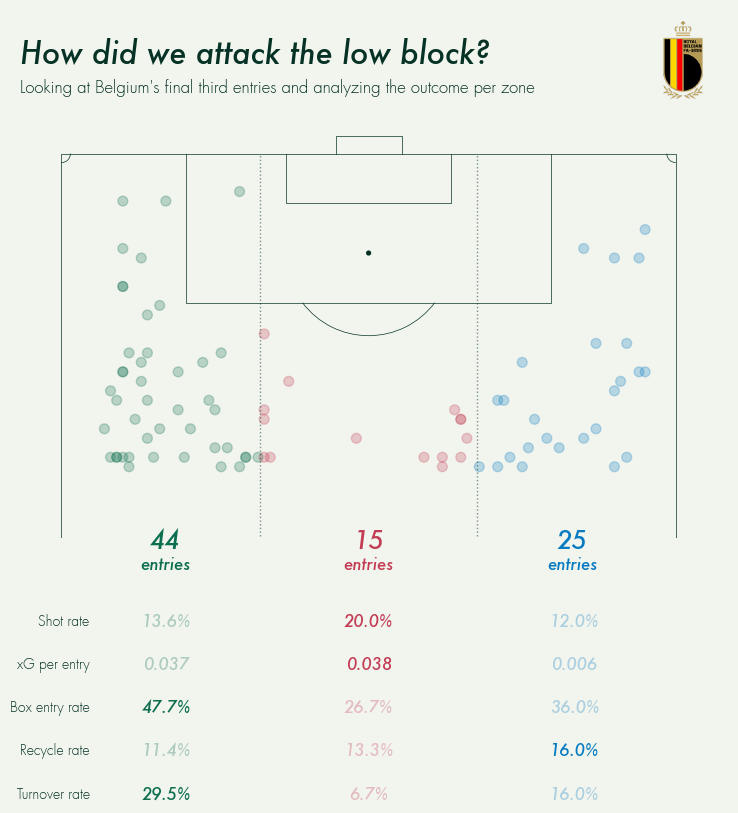

In [21]:
from viz import plot_final_third_entries

fig = plot_final_third_entries(entries_df, zone_stats, "Belgium")
fig.show()